In [2]:
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from IPython.display import HTML

# Enabling the caching of data, so it doesn't need to get downloaded every time
fastf1.plotting.setup_mpl(color_scheme='fastf1')

plt.rcParams['animation.embed_limit'] = 500.0

In [3]:
fastf1.Cache.enable_cache('cache')
session = fastf1.get_session(2024, 'Saudi Arabia', 'Q')
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '14', '81', '4', '63', '44', '22', '18', '38', '23', '20', '3', '27', '77', '31', '10', '2', '24']


# Getting familiar with the data

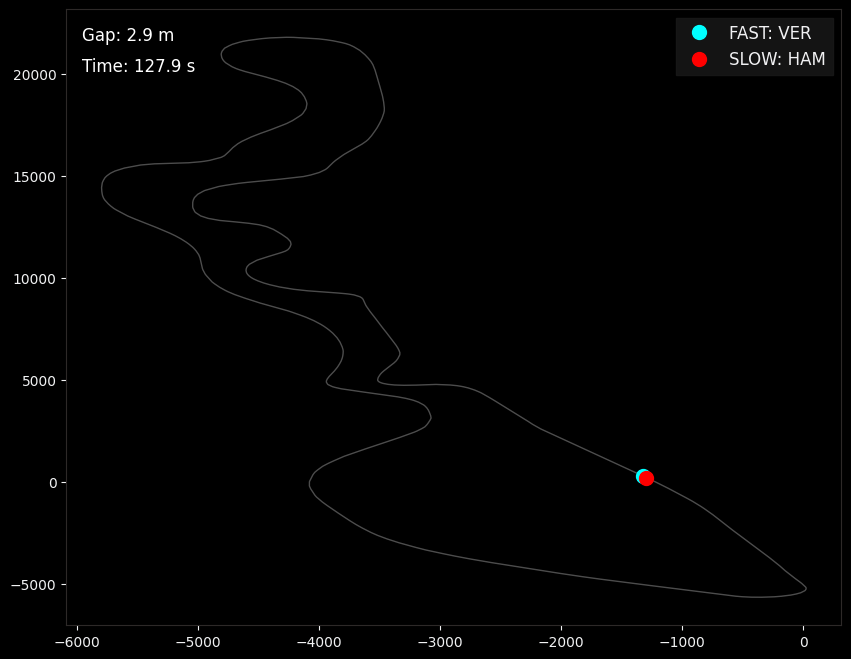

In [4]:
fast_lap = session.laps.pick_fastest()
fast_tel = fast_lap.get_telemetry()

# We need to find the slowest "Clean" lap, so one which doesn't include a pit stop and doesn't end with a crash

slow_lap = session.laps.pick_accurate().sort_values(by = 'LapTime', ascending = False).iloc[0]
slow_tel = slow_lap.get_telemetry()

# Now we map the time -> position so that we can visualize it all frame by frame
t_fast = fast_tel['Time'].dt.total_seconds()
t_slow = slow_tel['Time'].dt.total_seconds()

fast_time = t_fast - t_fast.iloc[0]
slow_time = t_slow - t_slow.iloc[0]

# Create a linear interpolation function where f(time) = position, linear to fill the gaps between the data points
f_fast_x = interp1d(fast_time, fast_tel['X'], fill_value = 'extrapolate')
f_fast_y = interp1d(fast_time, fast_tel['Y'], fill_value = 'extrapolate')
f_fast_dist = interp1d(fast_time, fast_tel['Distance'], fill_value  = 'extrapolate')

f_slow_x = interp1d(slow_time, slow_tel['X'], fill_value = 'extrapolate')
f_slow_y = interp1d(slow_time, slow_tel['Y'], fill_value = 'extrapolate')
f_slow_dist = interp1d(slow_time, slow_tel['Distance'], fill_value = 'extrapolate')

duration = max(fast_time.max(), slow_time.max())
fps = 15
total_frames = int(duration*fps)

fig, ax = plt.subplots(figsize = (10, 8))
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

ax.plot(fast_tel['X'], fast_tel['Y'], color = 'white', linewidth = 1, alpha = 0.3)

dot_fast, = ax.plot(fast_tel['X'].iloc[0], fast_tel['Y'].iloc[0], 'o', color = 'cyan', markersize = 10, label = f"FAST: {fast_lap['Driver']}", zorder = 5)
dot_slow, = ax.plot(slow_tel['X'].iloc[0], slow_tel['Y'].iloc[0], 'o', color = 'red', markersize = 10, label = f"SLOW: {slow_lap['Driver']}", zorder = 5)

ax.legend(loc='upper right', fontsize = 12)

delta_text = ax.text(0.02, 0.95, '', transform = ax.transAxes, color = 'white', fontsize = 12)
time_text = ax.text(0.02, 0.90, '', transform = ax.transAxes, color = 'white', fontsize = 12)

def update(frame):
    current_time = frame / fps

    # update positions
    if current_time <= fast_time.max():
        dot_fast.set_data([f_fast_x(current_time)], [f_fast_y(current_time)])
        d_fast = f_fast_dist(current_time)
    else:
        dot_fast.set_data([fast_tel['X'].iloc[-1]], [fast_tel['Y'].iloc[-1]])
        d_fast = fast_tel['Distance'].max()
    
    if current_time <= slow_time.max():
        dot_slow.set_data([f_slow_x(current_time)], [f_slow_y(current_time)])
        d_slow = f_slow_dist(current_time)
    else:
        dot_slow.set_data([slow_tel['X'].iloc[-1]], [slow_tel['Y'].iloc[-1]])
        d_slow = slow_tel['Distance'].max()
    
    gap_meters = d_fast - d_slow

    delta_text.set_text(f"Gap: {gap_meters:.1f} m")
    time_text.set_text(f"Time: {current_time:.1f} s")

    return dot_fast, dot_slow, delta_text, time_text

ani = FuncAnimation(fig, update, frames = total_frames, interval = 1000/fps, blit = True)

ani.save('race_animation.mp4', writer = 'ffmpeg', fps = 15)